Normalization parameters:

for real images: mean: 17.181818181818183 ; std: 15.545454545454545

for semi-synthetic: mean: 61.66156689772726 ; std: 36.4139976810122

for synthetic lines: mean: 51.227415953125 ; std: 31.554029192471624

real images, new annotations: mean: 595.7211111111111 ; std: 1159.925

In [1]:
from pathlib import Path

import os
import pylab as plt
from skimage import io
import numpy as np
import json
import torch
import argparse
import albumentations as A
from tracenet.utils.loader import get_loaders
from tracenet.utils.plot import plot_keypoints, plot_traces, show_imgs
from tracenet.models._utils import get_model

In [2]:
# data_dir = '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data_synth/lines_2D_400'
# img_dir = 'img'
# mean_std = (51.23, 31.55)

# data_dir = '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data/training_data'
# img_dir = 'img_synth'
# mean_std = (61.66, 36.41)

# data_dir = '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data/training_data'
# img_dir = 'img'
# mean_std = (17.18, 15.55)

# data_dir = '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data_synth/lines_2D_400_high_contrast'
# img_dir = 'img'
# gt_dir = 'csv'
# mean_std = (21.38, 23.5)

data_dir = '/research/sharedresources/cbi/data_exchange/hangrp/Development/mt_detection/data/training_data'
img_dir = 'img'
gt_dir = 'traces'
mean_std = (595.72, 1159.925)

model_path = rf'models_detr_mt/polar-feather-3/best_model.pth'

train_dir = 'train'
val_dir = 'val'
bs = 2

In [3]:
train_dl, val_dl = get_loaders(data_dir, train_dir=train_dir, val_dir=val_dir, 
                               img_dir=img_dir, gt_dir=gt_dir, batch_size=bs, 
                               mean_std=mean_std, shuffle=False)

In [4]:
imgs1, imgs2, targets = next(iter(val_dl));
ind = 0

Low image data range; displaying image with stretched contrast.


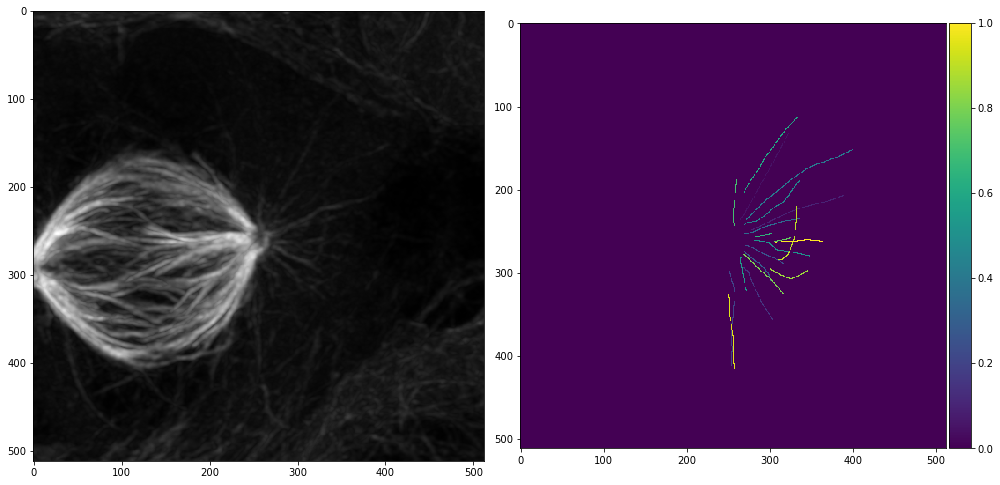

In [5]:
show_imgs([imgs1[ind][0], targets['labeled_mask'][ind]], s=7, norm=True)

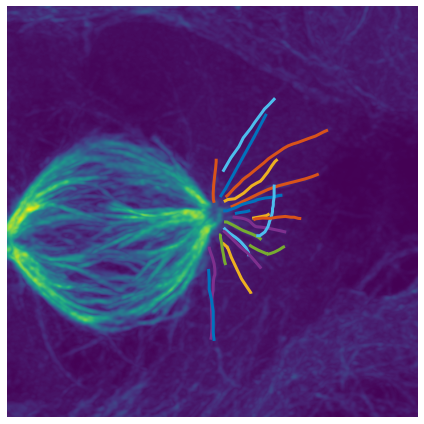

In [6]:
img_gt = plot_keypoints(imgs1[ind][0], targets['keypoints'][ind], targets['point_labels'][ind], return_image=True)

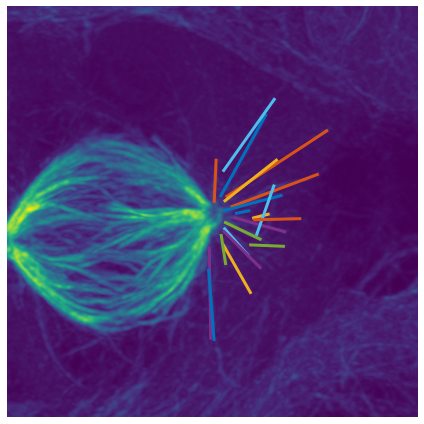

In [7]:
img_gt = plot_traces(imgs1[ind][0], targets['trace'][ind], return_image=True)

## Prediction

In [8]:
with open(os.path.join(os.path.dirname(model_path), 'config.json')) as f:
    config = json.load(f)
net = get_model(config=argparse.Namespace(**config))
net.load_state_dict(torch.load(model_path))
net.eval();

Using cache found in /home/amedyukh/.cache/torch/hub/facebookresearch_detr_main


__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


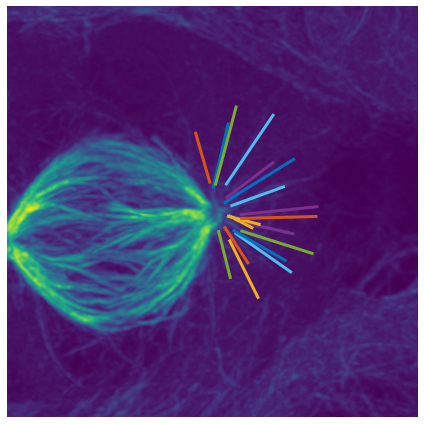

In [9]:
with torch.no_grad():
    outputs = net(imgs1)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[ind, :, 1:]
keep = probas.max(-1).values > 0.7
img_model = plot_traces(imgs1[ind][0], outputs['pred_traces'][ind, keep], return_image=True)

In [20]:
img_in = imgs1[ind][0].numpy()
img_in = img_in - np.min(img_in)
img_in = img_in / np.max(img_in)
per = np.percentile(img_in, 90)
img_in = np.clip(img_in, 0, per)

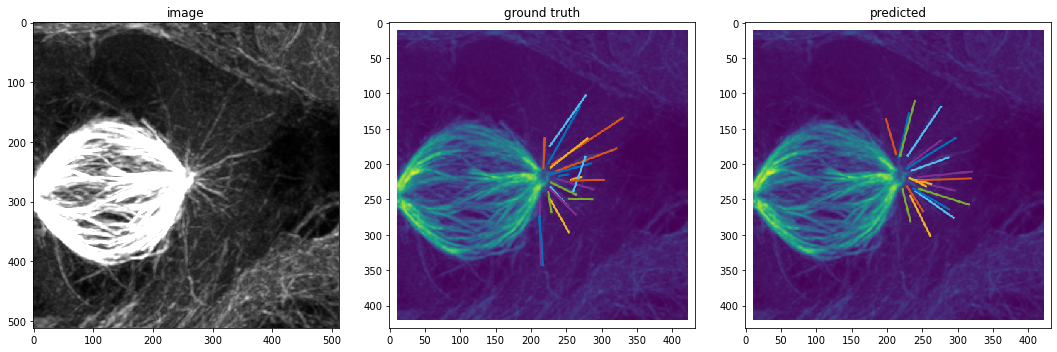

In [21]:
import pylab as plt
from skimage import io

fig, ax = plt.subplots(1, 3, figsize=(15,5))
titles = ['image', 'ground truth', 'predicted']
for i, im, in enumerate([img_in, img_gt, img_model]):
    im = im - im.min()
    im = im / im.max()
    plt.sca(ax[i])
    plt.title(titles[i])
    s = int(0.6*im.shape[0])
    io.imshow(im)